In [56]:
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
import datetime as dt
from tqdm.notebook import tqdm
from matplotlib.ticker import MaxNLocator, FuncFormatter,PercentFormatter
import math
import plotly.graph_objects as go
import matplotlib.cm as cm

from utils import read_pkl
from data import data_loader
from spread import spread_manager
from revert import df_to_inv_mom,df_to_dict

In [160]:
class stat_master:
    def __init__(self,data_obj,
                 coef_matrix_path='data/2024-01-01/t025imb05corr085typestd.pkl',
                 run_results_path='data/Results/-1_3_10_testing_good.pkl'):
        self.data = data_obj
        self.coef_matrix=read_pkl(coef_matrix_path)
        self.run_results=read_pkl(run_results_path)

        price_data=self.data.load_price()
        self.price_dict=df_to_dict(price_data)

        spreads=spread_manager(price_data,self.coef_matrix)
        spreads.calc_costs()
        signals=spreads.raw_signal()
        z_score=spreads.new_z_score()
        rev=-df_to_inv_mom(z_score)
        filterer=spreads.signal_z_score_filter()

        self.z_score=z_score

        self.signal_dict=df_to_dict(signals)
        self.rev_dict=df_to_dict(rev)
        self.filter_dict=df_to_dict(filterer)

    def remove_number(self,strings):
        return [' '.join(s.split()[:-1]) for s in strings]
    
    def coef_matrix_comp(self,coef_matrix):
        list_vals=self.remove_number(list(coef_matrix.index))

In [162]:
data=data_loader('2024-01-01')
stats_m=stat_master(data)

In [59]:
def remove_last_word(strings):
    return [' '.join(s.split()[:-1]) for s in strings]

list_indexes=list(stats.coef_matrix.index)
list_vals=(remove_last_word(list_indexes))



In [60]:
cat_cnts = pd.DataFrame(list_vals, columns=["Category"])
category_counts = cat_cnts["Category"].value_counts(normalize=True) * 100

threshold = 3  # Percentage below which categories are grouped
aggregated = category_counts[category_counts >= threshold]
aggregated["Other"] = category_counts[category_counts < threshold].sum()

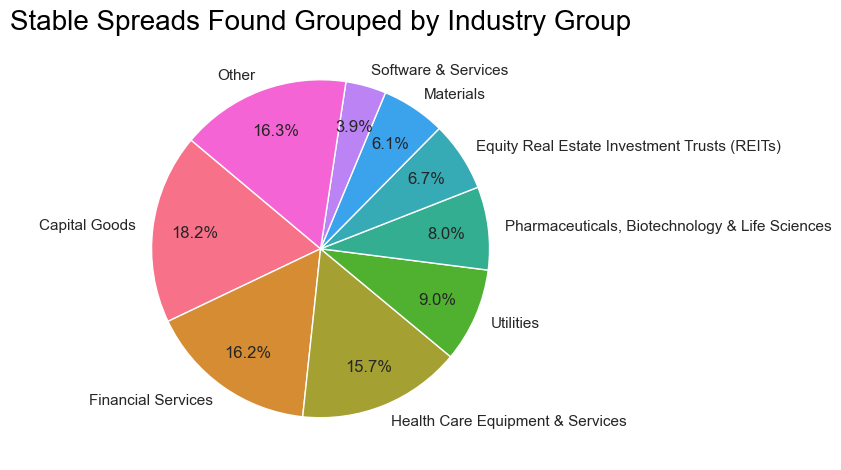

In [61]:

fig, ax = plt.subplots(figsize=(8, 8))
fig.patch.set_facecolor('none')
ax.set_facecolor('none')
sns.set_theme(style="whitegrid")
colors = sns.color_palette("husl", n_colors=len(aggregated))
plt.pie(
    aggregated, 
    labels=aggregated.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors,
    pctdistance=0.75,
    #textprops={'va': 'center', 'ha': 'center', 'fontsize': 10}
)
plt.tight_layout()
plt.title('Stable Spreads Found Grouped by Industry Group',fontsize=20)
fig.patch.set_facecolor('none')
plt.show()

In [62]:
start_date=dt.datetime(2023,12,31)
end_date=dt.datetime(2025,1,1)
testing_dates=stats.data.all_dates()[(stats.data.all_dates()>=pd.Timestamp(start_date))&(stats.data.all_dates()<pd.Timestamp(end_date))]

In [63]:
cnt_total=[]
prog=tqdm(total=len(testing_dates))
for date in testing_dates:
    temp_matrix=(stats.coef_matrix[stats.filter_dict[date]])
    temp_list=remove_last_word(list(temp_matrix.index))
    cat_cnts = pd.DataFrame(temp_list, columns=["Category"])
    category_counts = cat_cnts["Category"].value_counts()
    category_counts.name=date
    cnt_total.append(category_counts)
    prog.update(1)

  0%|          | 0/212 [00:00<?, ?it/s]

In [64]:
df_temp=pd.concat(cnt_total,axis=1).fillna(int(0))
df_new=df_temp.T.copy()

n_to_agg=15

df_new['Other'] = df_new.iloc[:, -n_to_agg:].sum(axis=1)
other_t=df_new['Other'].copy()
df_new.drop(columns=df_new.columns[-(n_to_agg+1):], inplace=True)
df_new['Other']=other_t

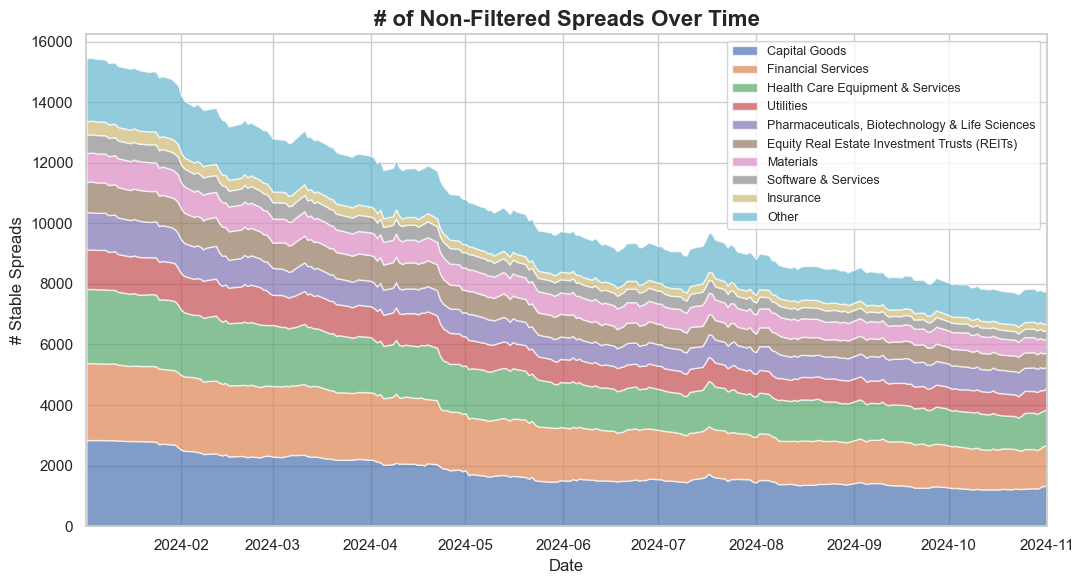

In [65]:
fig, ax = plt.subplots(figsize=(11, 6))
fig.patch.set_facecolor('none')
ax.set_facecolor('none')
sns.set_theme(style="whitegrid")
colors = sns.color_palette("husl", n_colors=len(list(df_new.columns)))
ax.stackplot(df_new.index, df_new.T, labels=df_new.columns,alpha=0.7)
ax.legend(loc='upper right',fontsize=9)
plt.title("# of Non-Filtered Spreads Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("# Stable Spreads")
plt.xlim(df_new.index[0],df_new.index[-1])
plt.tight_layout()
plt.show()

In [66]:
stats.run_results.keys()

dict_keys(['w_0s', 'w_1s', 'w_trade', 'start_vals', 'final_vals', 't_costs', 'loan_cost', 'short_int', 'mm_int', 'daily_pnl', 'net_pos', 'tot_pos', 'beta', 'vol', 'start_dates', 'end_dates'])

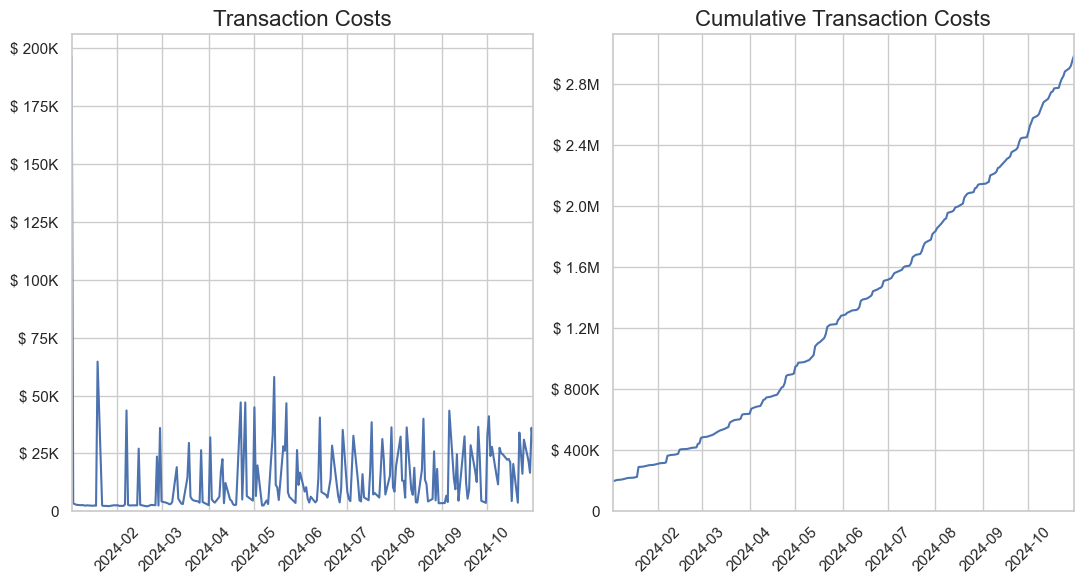

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(11, 6))  # 2 rows, 1 column grid
fig.patch.set_facecolor('none')
axes[0].set_facecolor('none')
axes[1].set_facecolor('none')

def format_ticks(x, pos):
    if x >= 1e6:
        return f'$ {x * 1e-6:.1f}M'
    elif x >= 1e3:
        return f'$ {x * 1e-3:.0f}K'
    else:
        return str(int(x))

# First plot
axes[0].plot(stats.run_results['start_dates'], (np.array(stats.run_results['t_costs'])))
axes[0].set_title("Transaction Costs",fontsize=16)
axes[0].set_ylim(0)
axes[0].set_xlim([stats.run_results['start_dates'][0],stats.run_results['start_dates'][-1]])
axes[0].tick_params(axis='x', labelrotation=45)

# Second plot
axes[1].plot(stats.run_results['start_dates'], np.cumsum(np.array(stats.run_results['t_costs'])))
axes[1].set_title("Cumulative Transaction Costs",fontsize=16)
axes[1].set_ylim(0)
axes[1].set_xlim([stats.run_results['start_dates'][0],stats.run_results['start_dates'][-1]])
axes[1].tick_params(axis='x', labelrotation=45)

axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))

axes[0].yaxis.set_major_formatter(FuncFormatter(format_ticks))
axes[1].yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.tight_layout()
plt.show()

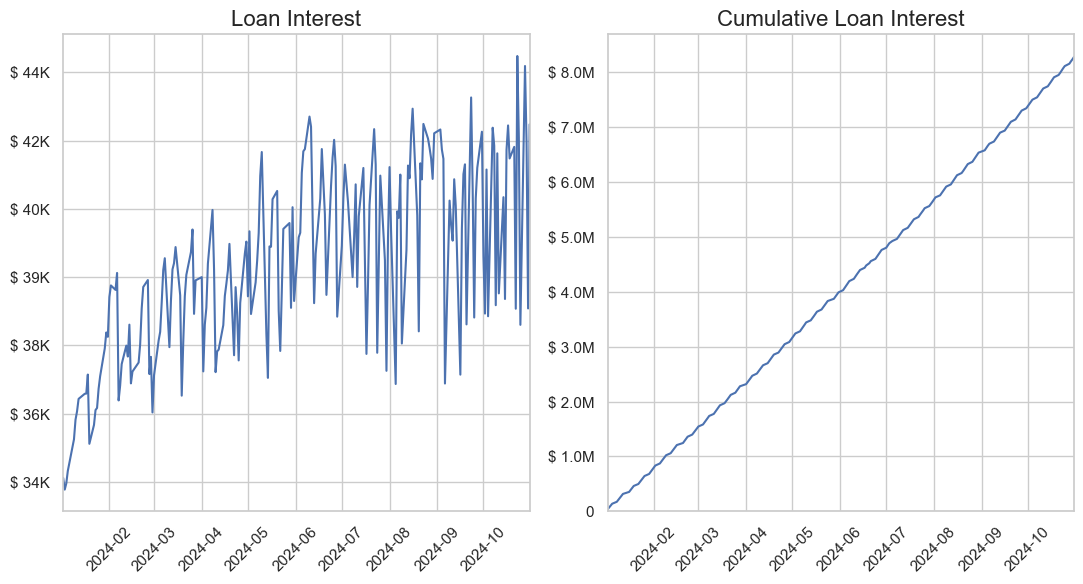

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(11, 6))  # 2 rows, 1 column grid
fig.patch.set_facecolor('none')
axes[0].set_facecolor('none')
axes[1].set_facecolor('none')

def format_ticks(x, pos):
    if x >= 1e6:
        return f'$ {x * 1e-6:.1f}M'
    elif x >= 1e3:
        return f'$ {x * 1e-3:.0f}K'
    else:
        return str(int(x))

# First plot
axes[0].plot(stats.run_results['start_dates'], (np.array(stats.run_results['loan_cost'])))
axes[0].set_title("Loan Interest",fontsize=16)
axes[0].set_xlim([stats.run_results['start_dates'][0],stats.run_results['start_dates'][-1]])
axes[0].tick_params(axis='x', labelrotation=45)

# Second plot
axes[1].plot(stats.run_results['start_dates'], np.cumsum(np.array(stats.run_results['loan_cost'])))
axes[1].set_title("Cumulative Loan Interest",fontsize=16)
axes[1].set_ylim(0)
axes[1].set_xlim([stats.run_results['start_dates'][0],stats.run_results['start_dates'][-1]])
axes[1].tick_params(axis='x', labelrotation=45)

axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))

axes[0].yaxis.set_major_formatter(FuncFormatter(format_ticks))
axes[1].yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.tight_layout()
plt.show()

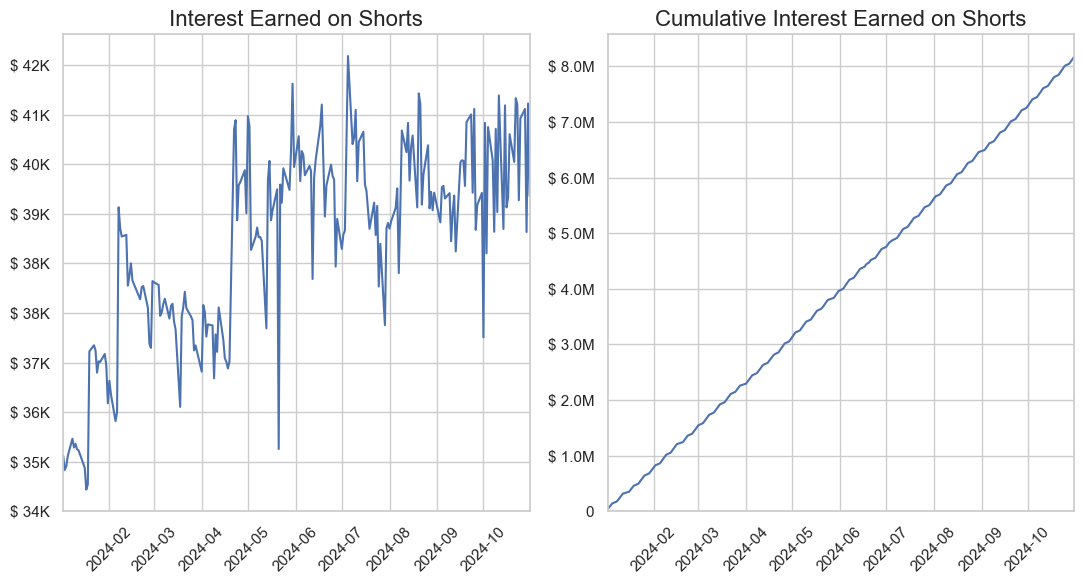

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(11, 6))  # 2 rows, 1 column grid
fig.patch.set_facecolor('none')
axes[0].set_facecolor('none')
axes[1].set_facecolor('none')

def format_ticks(x, pos):
    if x >= 1e6:
        return f'$ {x * 1e-6:.1f}M'
    elif x >= 1e3:
        return f'$ {x * 1e-3:.0f}K'
    else:
        return str(int(x))

# First plot
axes[0].plot(stats.run_results['start_dates'], (np.array(stats.run_results['short_int'])))
axes[0].set_title("Interest Earned on Shorts",fontsize=16)
axes[0].set_xlim([stats.run_results['start_dates'][0],stats.run_results['start_dates'][-1]])
axes[0].tick_params(axis='x', labelrotation=45)

# Second plot
axes[1].plot(stats.run_results['start_dates'], np.cumsum(np.array(stats.run_results['short_int'])))
axes[1].set_title("Cumulative Interest Earned on Shorts",fontsize=16)
axes[1].set_ylim(0)
axes[1].set_xlim([stats.run_results['start_dates'][0],stats.run_results['start_dates'][-1]])
axes[1].tick_params(axis='x', labelrotation=45)

axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))

axes[0].yaxis.set_major_formatter(FuncFormatter(format_ticks))
axes[1].yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.tight_layout()
plt.show()

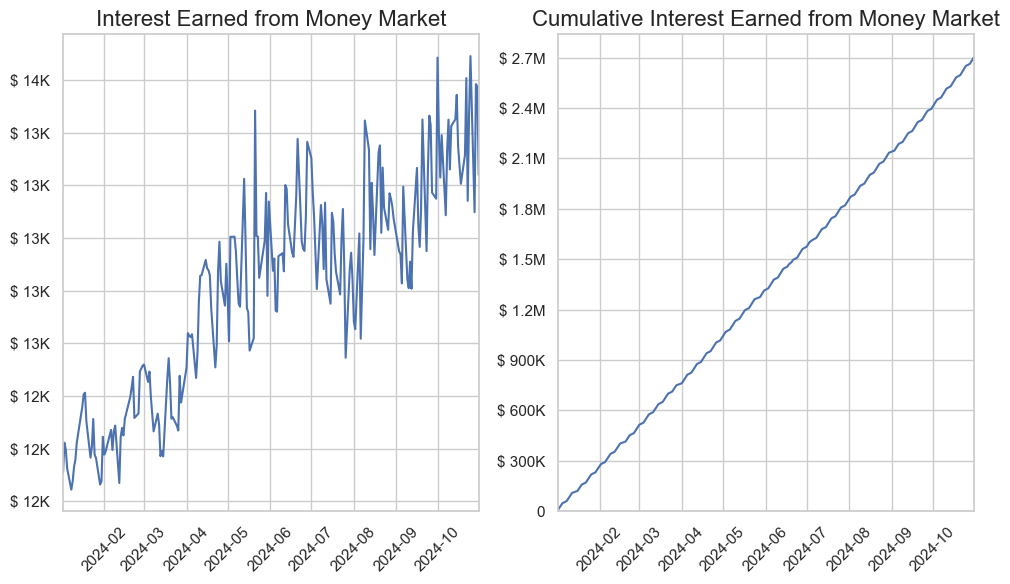

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))  # 2 rows, 1 column grid
fig.patch.set_facecolor('none')
axes[0].set_facecolor('none')
axes[1].set_facecolor('none')

def format_ticks(x, pos):
    if x >= 1e6:
        return f'$ {x * 1e-6:.1f}M'
    elif x >= 1e3:
        return f'$ {x * 1e-3:.0f}K'
    else:
        return str(int(x))

# First plot
axes[0].plot(stats.run_results['start_dates'], (np.array(stats.run_results['mm_int'])))
axes[0].set_title("Interest Earned from Money Market",fontsize=16)
axes[0].set_xlim([stats.run_results['start_dates'][0],stats.run_results['start_dates'][-1]])
axes[0].tick_params(axis='x', labelrotation=45)

# Second plot
axes[1].plot(stats.run_results['start_dates'], np.cumsum(np.array(stats.run_results['mm_int'])))
axes[1].set_title("Cumulative Interest Earned from Money Market",fontsize=16)
axes[1].set_ylim(0)
axes[1].set_xlim([stats.run_results['start_dates'][0],stats.run_results['start_dates'][-1]])
axes[1].tick_params(axis='x', labelrotation=45)

axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))

axes[0].yaxis.set_major_formatter(FuncFormatter(format_ticks))
axes[1].yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.tight_layout()
plt.show()

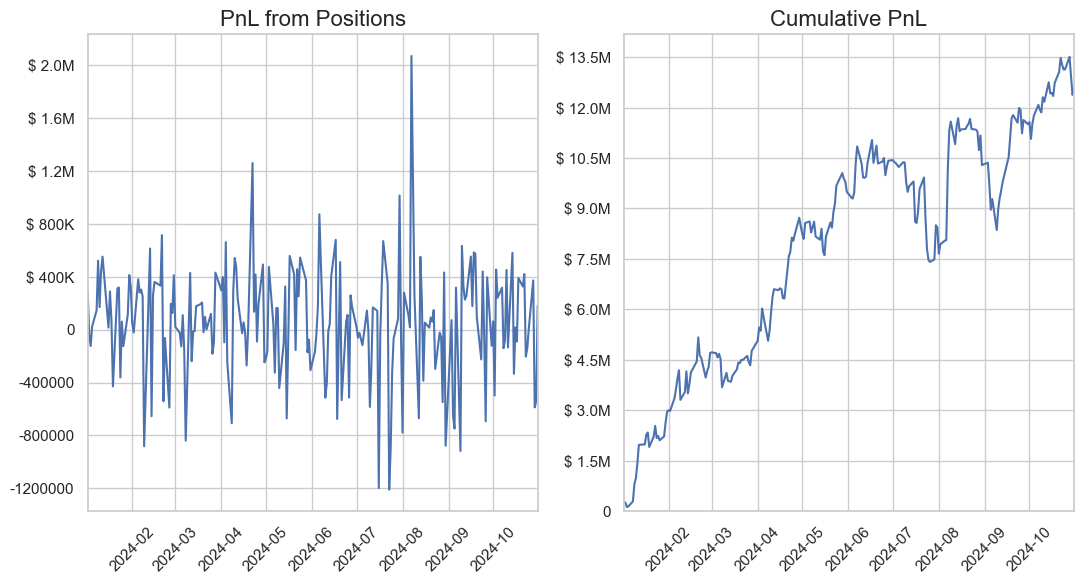

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(11, 6))  # 2 rows, 1 column grid
fig.patch.set_facecolor('none')
axes[0].set_facecolor('none')
axes[1].set_facecolor('none')

def format_ticks(x, pos):
    if x >= 1e6:
        return f'$ {x * 1e-6:.1f}M'
    elif x >= 1e3:
        return f'$ {x * 1e-3:.0f}K'
    else:
        return str(int(x))

# First plot
axes[0].plot(stats.run_results['start_dates'], (np.array(stats.run_results['daily_pnl'])))
axes[0].set_title("PnL from Positions",fontsize=16)
axes[0].set_xlim([stats.run_results['start_dates'][0],stats.run_results['start_dates'][-1]])
axes[0].tick_params(axis='x', labelrotation=45)

# Second plot
axes[1].plot(stats.run_results['start_dates'], np.cumsum(np.array(stats.run_results['daily_pnl'])))
axes[1].set_title("Cumulative PnL",fontsize=16)
axes[1].set_ylim(0)
axes[1].set_xlim([stats.run_results['start_dates'][0],stats.run_results['start_dates'][-1]])
axes[1].tick_params(axis='x', labelrotation=45)

axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))

axes[0].yaxis.set_major_formatter(FuncFormatter(format_ticks))
axes[1].yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.tight_layout()
plt.show()

In [72]:
print(np.sum(stats.run_results['daily_pnl']))
print(np.sum(stats.run_results['mm_int']))
print(np.sum(stats.run_results['short_int']))
print(np.sum(stats.run_results['loan_cost']))
print(np.sum(stats.run_results['t_costs']))

12557901.121856857
2702809.576228614
8170130.676641826
8281883.417355572
2988641.844956278


In [73]:
resultsmlam1=read_pkl('data/Results/0_3_10_testing_mining.pkl')
resultsplam1=read_pkl('data/Results/-2_3_10_testing_mining.pkl')

resultsmlam2=read_pkl('data/Results/-1_2_10_testing_mining.pkl')
resultsplam2=read_pkl('data/Results/-1_4_10_testing_mining.pkl')

resultsmlam3=read_pkl('data/Results/-1_3_5_testing_mining.pkl')
resultsplam3=read_pkl('data/Results/-1_3_15_testing_mining.pkl')

results=read_pkl('data/Results/-1_3_10_testing_good.pkl')

In [74]:
results.keys()

dict_keys(['w_0s', 'w_1s', 'w_trade', 'start_vals', 'final_vals', 't_costs', 'loan_cost', 'short_int', 'mm_int', 'daily_pnl', 'net_pos', 'tot_pos', 'beta', 'vol', 'start_dates', 'end_dates'])

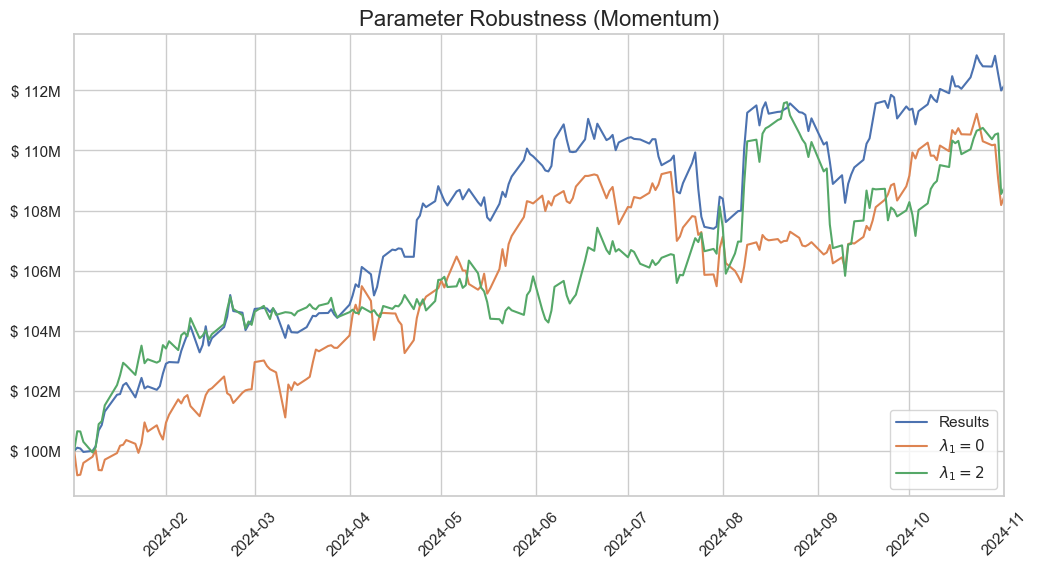

In [75]:
fig, ax = plt.subplots(figsize=(12,6))

def format_ticks_2(x, pos):
    if x >= 1e6:
        return f'$ {x * 1e-6:.0f}M'
    elif x >= 1e3:
        return f'$ {x * 1e-3:.0f}K'
    else:
        return str(int(x))
colors = sns.color_palette("husl", n_colors=10)
ax.plot([results['start_dates'][0]]+results['end_dates'],[results['start_vals'][0]]+results['final_vals'],label='Results')
ax.plot([resultsmlam1['start_dates'][0]]+resultsmlam1['end_dates'],[resultsmlam1['start_vals'][0]]+resultsmlam1['final_vals'],label=r'$\lambda_1 = 0$')
ax.plot([resultsplam1['start_dates'][0]]+resultsplam1['end_dates'],[resultsplam1['start_vals'][0]]+resultsplam1['final_vals'],label=r'$\lambda_1 = 2$')
ax.set_title('Parameter Robustness (Momentum)',fontsize=16)
ax.set_xlim(resultsmlam1['start_dates'][0],resultsmlam1['end_dates'][-1])
ax.legend(loc='lower right')
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks_2))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='x', labelrotation=45)
plt.show()

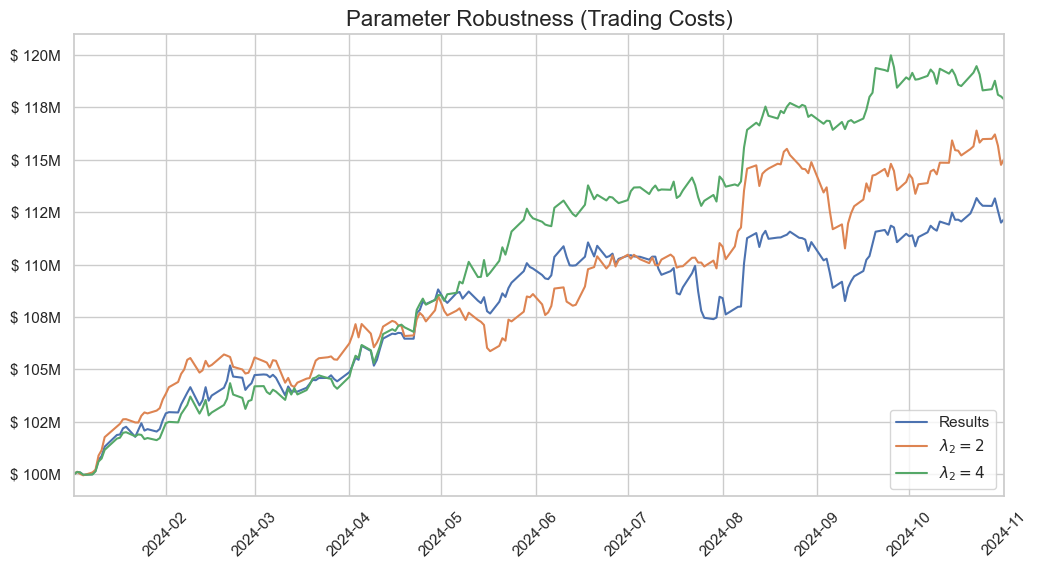

In [76]:
fig, ax = plt.subplots(figsize=(12,6))
colors = sns.color_palette("husl", n_colors=10)
ax.plot([results['start_dates'][0]]+results['end_dates'],[results['start_vals'][0]]+results['final_vals'],label='Results')
ax.plot([resultsmlam2['start_dates'][0]]+resultsmlam2['end_dates'],[resultsmlam2['start_vals'][0]]+resultsmlam2['final_vals'],label=r'$\lambda_2 = 2$')
ax.plot([resultsplam2['start_dates'][0]]+resultsplam2['end_dates'],[resultsplam2['start_vals'][0]]+resultsplam2['final_vals'],label=r'$\lambda_2 = 4$')
ax.set_title('Parameter Robustness (Trading Costs)',fontsize=16)
ax.set_xlim(resultsmlam1['start_dates'][0],resultsmlam1['end_dates'][-1])
ax.legend(loc='lower right')
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks_2))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='x', labelrotation=45)
plt.show()

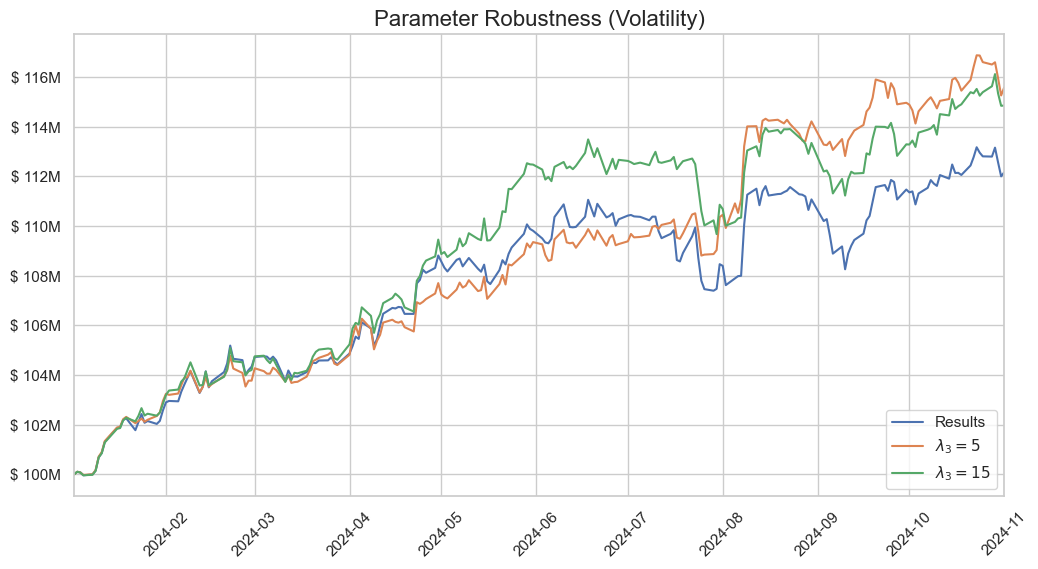

In [77]:
fig, ax = plt.subplots(figsize=(12,6))
colors = sns.color_palette("husl", n_colors=10)
ax.plot([results['start_dates'][0]]+results['end_dates'],[results['start_vals'][0]]+results['final_vals'],label='Results')
ax.plot([resultsmlam3['start_dates'][0]]+resultsmlam3['end_dates'],[resultsmlam3['start_vals'][0]]+resultsmlam3['final_vals'],label=r'$\lambda_3 = 5$')
ax.plot([resultsplam3['start_dates'][0]]+resultsplam3['end_dates'],[resultsplam3['start_vals'][0]]+resultsplam3['final_vals'],label=r'$\lambda_3 = 15$')
ax.set_title('Parameter Robustness (Volatility)',fontsize=16)
ax.set_xlim(resultsmlam1['start_dates'][0],resultsmlam1['end_dates'][-1])
ax.legend(loc='lower right')
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks_2))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='x', labelrotation=45)
plt.show()

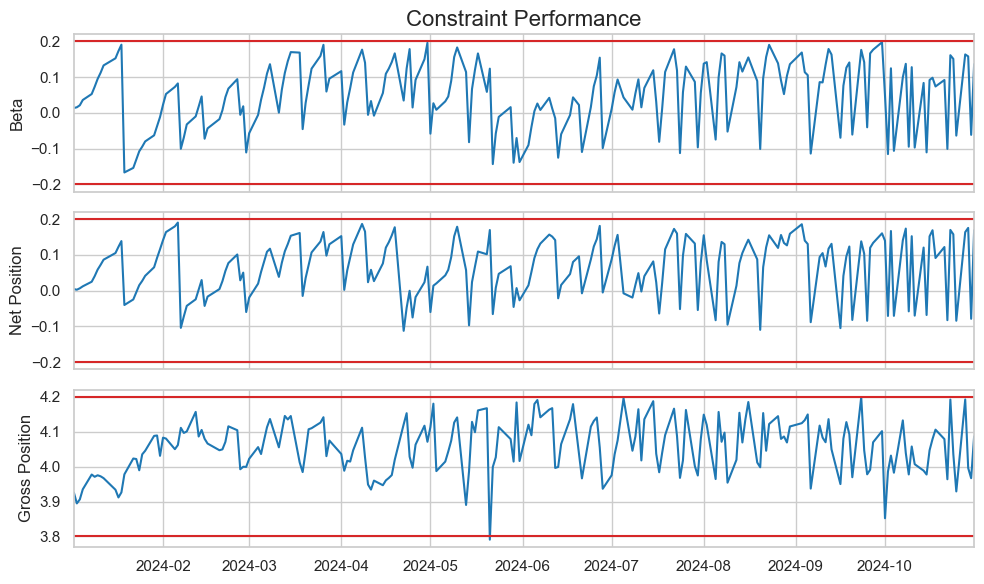

In [78]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 6))
colors = sns.color_palette("husl", n_colors=6)
ax1.set_title('Constraint Performance',fontsize=16)
ax1.plot(results['start_dates'],results['beta'],label='Portfolio Beta',c=sns.color_palette("Paired")[1])
ax1.plot([results['start_dates'][0],results['start_dates'][-1]],[0.2,0.2],label='Upper Bound',c=sns.color_palette('tab10')[3])
ax1.plot([results['start_dates'][0],results['start_dates'][-1]],[-0.2,-0.2],label='Lower Bound',c=sns.color_palette('tab10')[3])
ax1.set_xlim(results['start_dates'][0],results['start_dates'][-1])
ax1.set_ylabel('Beta')
ax2.plot(results['start_dates'],results['net_pos'],label='Portfolio Beta',c=sns.color_palette("Paired")[1])
ax2.plot([results['start_dates'][0],results['start_dates'][-1]],[0.2,0.2],label='Upper Bound',c=sns.color_palette('tab10')[3])
ax2.plot([results['start_dates'][0],results['start_dates'][-1]],[-0.2,-0.2],label='Lower Bound',c=sns.color_palette('tab10')[3])
ax2.set_xlim(results['start_dates'][0],results['start_dates'][-1])
ax2.set_ylabel('Net Position')

ax3.plot(results['start_dates'],results['tot_pos'],label='Portfolio Beta',c=sns.color_palette("Paired")[1])
ax3.plot([results['start_dates'][0],results['start_dates'][-1]],[4.2,4.2],label='Upper Bound',c=sns.color_palette('tab10')[3])
ax3.plot([results['start_dates'][0],results['start_dates'][-1]],[3.8,3.8],label='Lower Bound',c=sns.color_palette('tab10')[3])
ax3.set_xlim(results['start_dates'][0],results['start_dates'][-1])
ax3.set_ylabel('Gross Position')
#ax3.tick_params(axis='x', labelrotation=45)

plt.tight_layout()

In [79]:
training_dates=stats.data.all_dates()[(stats.data.all_dates()<pd.Timestamp(dt.date(2024,1,1)))]
testing_dates=stats.data.all_dates()[(stats.data.all_dates()>pd.Timestamp(dt.date(2024,1,1)))]

In [80]:
print(testing_dates.shape)
print(training_dates.shape)

(212,)
(753,)


In [81]:
stats.data.all_dates().shape

(965,)

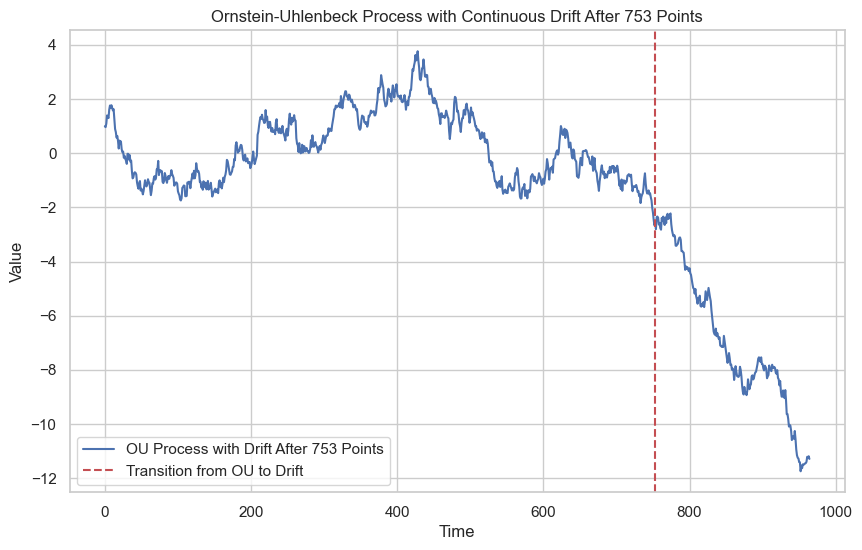

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the Ornstein-Uhlenbeck process
theta = 0.15  # Mean reversion speed
mu = 0.0      # Long-term mean
sigma = 2   # Volatility
dt = 0.01     # Time step
n_ou = 753    # Number of points for the OU process

# Parameters for the continuous drift after 753 points
beta = -8   # Constant drift after 753 points
n_total = 965 # Total number of points

# Seed for reproducibility
np.random.seed(42)

# Simulate the first part (OU process for 753 points)
ou_process = np.zeros(n_total)
ou_process[0] = np.random.normal(mu, sigma)  # Initial value

# First part: Simulate OU process (for 753 points)
for t in range(1, n_ou):
    dW = np.random.normal(0, np.sqrt(dt))  # Wiener increment
    ou_process[t] = ou_process[t-1] + theta * (mu - ou_process[t-1]) * dt + sigma * dW

# Second part: Continuous drift after 753 points
for t in range(n_ou, n_total):
    dW = np.random.normal(0, np.sqrt(dt))  # Wiener increment
    ou_process[t] = ou_process[t-1] + beta * dt + sigma * dW

# Plot the combined process
plt.figure(figsize=(10, 6))
plt.plot(np.arange(n_total), ou_process, label="OU Process with Drift After 753 Points")
plt.axvline(x=n_ou, color='r', linestyle='--', label="Transition from OU to Drift")
plt.title('Ornstein-Uhlenbeck Process with Continuous Drift After 753 Points')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


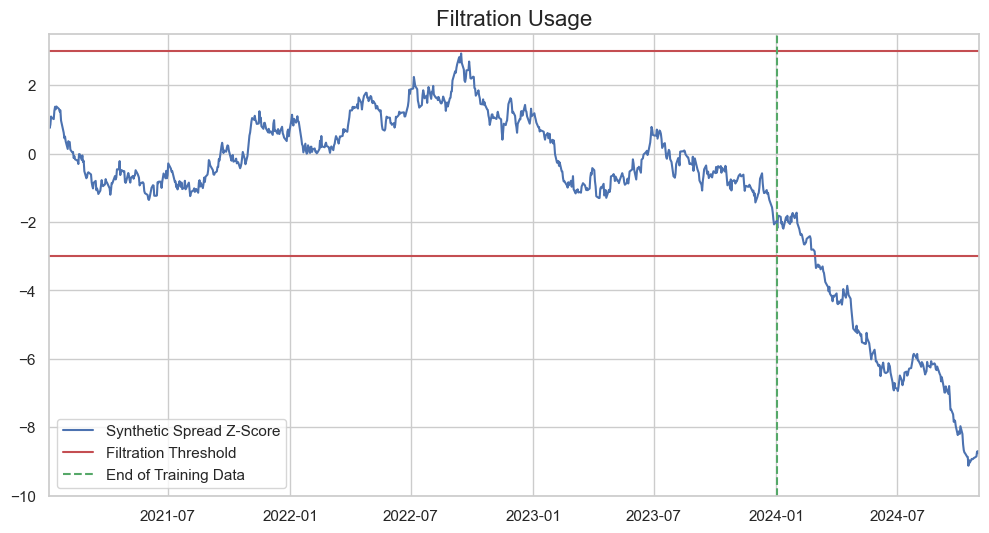

In [83]:
plt.figure(figsize=(12, 6))
stdev_training=np.std(ou_process[:753])
plt.plot(stats.data.all_dates(),ou_process/stdev_training,label='Synthetic Spread Z-Score')
plt.xlim(stats.data.all_dates()[0],stats.data.all_dates()[-1])
plt.plot([stats.data.all_dates()[0],stats.data.all_dates()[-1]],[3,3],c='r',label='Filtration Threshold')
plt.plot([stats.data.all_dates()[0],stats.data.all_dates()[-1]],[-3,-3],c='r')
plt.plot([stats.data.all_dates()[753],stats.data.all_dates()[753]],[-10,4],linestyle='--',label='End of Training Data',c='g')
plt.legend()
plt.ylim(-10,3.5)
plt.title('Filtration Usage',fontsize=16)
plt.show()

In [84]:
stats.z_score

,Automobiles & Components 1,Banks 1,Banks 2,Banks 3,Banks 4,Banks 5,Banks 6,Banks 7,Banks 8,Banks 9,...,Utilities 1402,Utilities 1403,Utilities 1404,Utilities 1405,Utilities 1406,Utilities 1407,Utilities 1408,Utilities 1409,Utilities 1410,Utilities 1411
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,1.768597,0.810863,0.092594,0.436338,0.780427,0.062920,0.171641,0.919598,-0.000449,0.981753,...,0.183300,-2.140838,0.719256,0.193484,0.362941,0.157309,-0.080927,-1.307674,-1.040201,1.206203
2021-01-05,1.815771,0.152103,0.107732,0.492762,1.224376,0.421904,0.300880,0.783932,-0.252231,0.855968,...,0.107328,-1.629826,0.581088,0.005400,0.067864,0.204200,-0.213383,-1.181036,-0.789676,1.066544
2021-01-06,1.879998,0.192230,0.470663,0.680533,1.424711,0.499289,1.041849,1.189758,0.419138,0.926595,...,-0.307218,-1.835637,-0.309744,-0.072038,-1.073069,-0.897421,-0.759568,-1.414288,-1.057451,0.838326
2021-01-07,2.343783,-0.167845,0.333618,0.266479,1.282271,0.331787,0.419296,0.733741,-0.022641,0.267975,...,-0.855271,-1.937695,-0.903457,-0.769566,-1.704902,-1.646507,-1.075783,-1.643675,-0.936017,0.666636
2021-01-08,2.427234,0.141376,0.577144,0.468608,1.161657,0.403851,0.575449,0.879909,0.157733,0.557304,...,-0.433048,-1.424377,-0.795690,-0.882785,-1.691061,-1.554437,-0.520846,-1.183637,-0.862168,1.318806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-28,-8.916327,1.642352,-1.284104,-0.225030,-2.759160,-1.499153,0.713209,-0.573584,0.333595,-1.817517,...,-2.633109,-2.098617,3.796147,-3.034825,0.536510,0.651873,-2.546079,-5.231128,-6.446592,-0.529710
2024-10-29,-8.908452,1.398198,-1.413461,-0.289390,-2.639496,-1.455147,0.826795,-0.613714,0.293869,-1.796396,...,-2.663498,-2.387143,3.346378,-3.310315,0.288103,0.384656,-2.653878,-5.634253,-6.812258,-0.921122
2024-10-30,-9.002199,1.763819,-1.348757,-0.398494,-2.893800,-1.714720,0.477023,-1.024837,-0.449521,-2.206483,...,-2.166583,-2.131260,3.568807,-4.211673,0.592344,0.652469,-2.883710,-5.393902,-6.469361,-0.651778


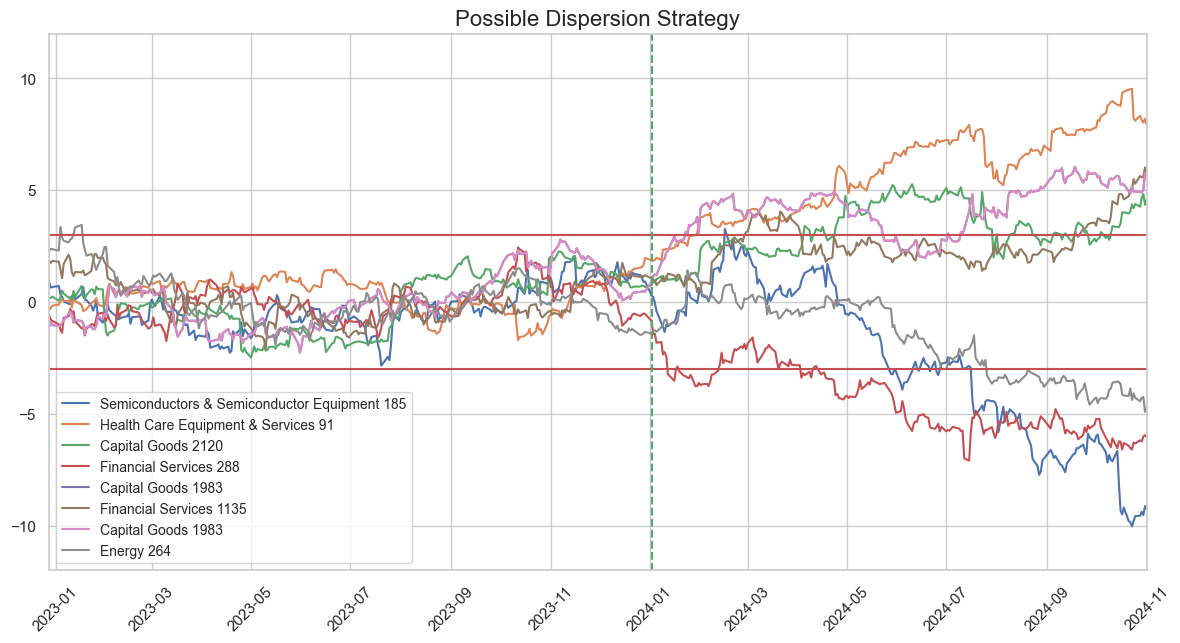

In [85]:
date_tem=list(stats.z_score.index)
plt.figure(figsize=(12, 6))
plt.plot(date_tem,stats.z_score['Semiconductors & Semiconductor Equipment 185'],label='Semiconductors & Semiconductor Equipment 185')
plt.plot(date_tem,stats.z_score['Health Care Equipment & Services 91'],label='Health Care Equipment & Services 91')
plt.plot(date_tem,stats.z_score['Capital Goods 2120'],label='Capital Goods 2120')
plt.plot(date_tem,stats.z_score['Financial Services 288'],label='Financial Services 288')
plt.plot(date_tem,stats.z_score['Capital Goods 1983'],label='Capital Goods 1983')
plt.plot(date_tem,stats.z_score['Financial Services 1135'],label='Financial Services 1135')
plt.plot(date_tem,stats.z_score['Capital Goods 1983'],label='Capital Goods 1983')
plt.plot(date_tem,stats.z_score['Energy 264'],label='Energy 264')
plt.plot([stats.data.all_dates()[0],stats.data.all_dates()[-1]],[3,3],c='r')
plt.plot([stats.data.all_dates()[0],stats.data.all_dates()[-1]],[-3,-3],c='r')
plt.plot([stats.data.all_dates()[753],stats.data.all_dates()[753]],[-15,15],linestyle='--',c='g')
plt.xlim(date_tem[500],date_tem[-1])
plt.ylim(-12,12)
plt.legend(fontsize=10,loc='lower left')
plt.tight_layout()
plt.title('Possible Dispersion Strategy',fontsize=16)
plt.tick_params('x',rotation=45)
plt.show()

In [86]:
data_groups=stats.data.data['Group Data']

total_checks=0

for group in data_groups.keys():
    group_cnt=0
    group_size=len(data_groups[group])
    for i in range(2,6):
        group_cnt+=(math.comb(group_size,i)*(i+1))
    total_checks+=group_cnt

print(total_checks)

20301380


In [87]:
for group in data_groups.keys():
    group_cnt=0
    group_size=len(data_groups[group])
    print(group,group_size)

Automobiles & Components 5
Banks 15
Capital Goods 48
Commercial & Professional Services 15
Consumer Discretionary Distribution & Retail 17
Consumer Durables & Apparel 13
Consumer Services 18
Consumer Staples Distribution & Retail 8
Energy 22
Equity Real Estate Investment Trusts (REITs) 29
Financial Services 35
Food, Beverage & Tobacco 23
Health Care Equipment & Services 35
Household & Personal Products 6
Insurance 22
Materials 27
Media & Entertainment 19
Pharmaceuticals, Biotechnology & Life Sciences 28
Real Estate Management & Development 2
Semiconductors & Semiconductor Equipment 20
Software & Services 24
Technology Hardware & Equipment 20
Telecommunication Services 3
Transportation 14
Utilities 29


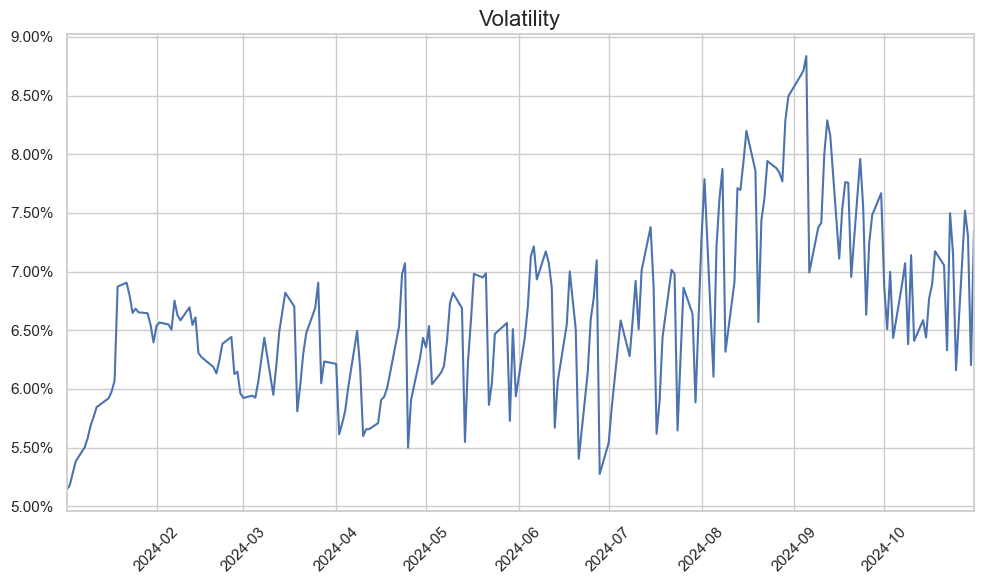

In [88]:
plt.figure(figsize=(10,6))
plt.plot(results['start_dates'],results['vol'])
plt.xlim(results['start_dates'][0],results['start_dates'][-1])
plt.title('Volatility',fontsize=16)
plt.tick_params('x',rotation=45)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.tight_layout()
plt.show()

In [89]:
results.keys()

dict_keys(['w_0s', 'w_1s', 'w_trade', 'start_vals', 'final_vals', 't_costs', 'loan_cost', 'short_int', 'mm_int', 'daily_pnl', 'net_pos', 'tot_pos', 'beta', 'vol', 'start_dates', 'end_dates'])

In [90]:
print(np.sum(results['t_costs']))
print(np.sum(results['loan_cost']))
print(np.sum(results['short_int']))
print(np.sum(results['mm_int']))
print(np.sum(results['daily_pnl']))

2988641.844956278
8281883.417355572
8170130.676641826
2702809.576228614
12557901.121856857


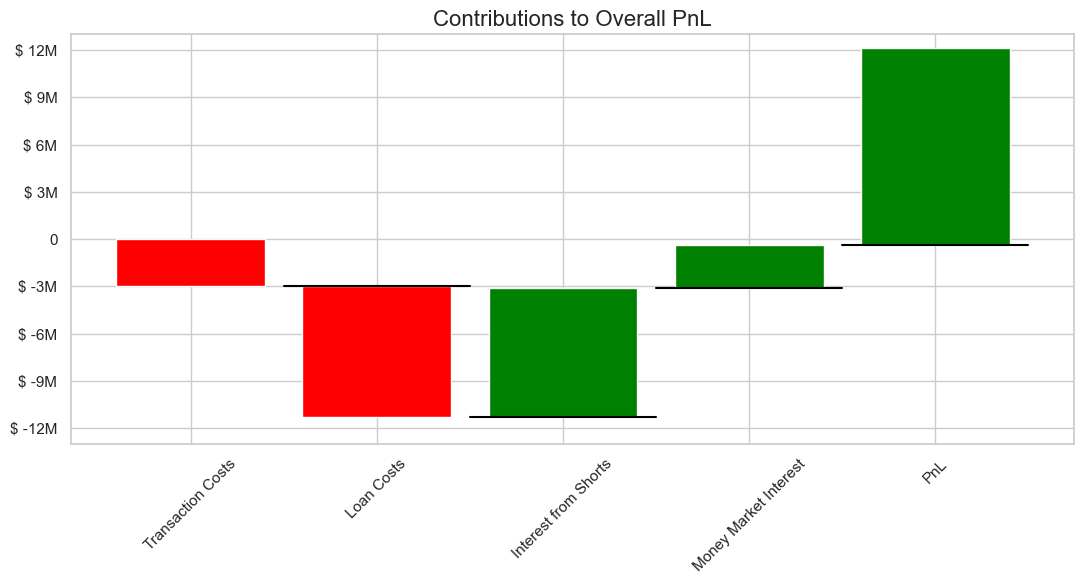

In [91]:
def format_ticks_2(x, pos):
    if abs(x) >= 1e6:
        return f'$ {x * 1e-6:.0f}M'
    elif abs(x) >= 1e3:
        return f'$ {x * 1e-3:.0f}K'
    else:
        return str(int(x))

def waterfall_chart(categories, values, title=None):
    """Creates a waterfall chart using Matplotlib."""

    # Calculate cumulative values
    cumulative = np.cumsum(values)

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(11,6))

    # Plot the bars
    for i, (cat, val) in enumerate(zip(categories, values)):
        if val >= 0:
            color = 'green'
        else:
            color = 'red'

        ax.bar(i, val, bottom=cumulative[i-1] if i > 0 else 0, color=color)

    # Add lines between bars
    for i in range(len(categories) - 1):
        ax.plot([i + 0.5, i + 1.5], [cumulative[i], cumulative[i]], color='black')
    plt.ylim(-13e6,13e6)
    # Set x-axis labels and title
    ax.set_xticks(np.arange(len(categories)))
    ax.set_xticklabels(categories)
    if title:
        ax.set_title(title)
    plt.title('Contributions to Overall PnL',fontsize=16)
    plt.tick_params('x',rotation=45)
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks_2))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    # Show the plot
    plt.show()

categories=['Transaction Costs','Loan Costs', 'Interest from Shorts', 'Money Market Interest', 'PnL']
values=[-np.sum(results['t_costs']),-np.sum(results['loan_cost']),np.sum(results['short_int']),np.sum(results['mm_int']),np.sum(results['daily_pnl'])]

waterfall_chart(categories,values)

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the Ornstein-Uhlenbeck process
theta = 0.5  # Mean reversion speed
mu = 0.0      # Long-term mean
sigma = 2   # Volatility
dt = 0.01     # Time step
n_ou = 753    # Number of points for the OU process

# Parameters for the continuous drift after 753 points
beta = 0   # Constant drift after 753 points
n_total = 965 # Total number of points

# Seed for reproducibility
np.random.seed(1)

# Simulate the first part (OU process for 753 points)
ou_process = np.zeros(n_total)
ou_process[0] = np.random.normal(mu, sigma)  # Initial value

# First part: Simulate OU process (for 753 points)
for t in range(1, n_ou):
    dW = np.random.normal(0, np.sqrt(dt))  # Wiener increment
    ou_process[t] = ou_process[t-1] + theta * (mu - ou_process[t-1]) * dt + sigma * dW

# Second part: Continuous drift after 753 points
for t in range(n_ou, n_total):
    dW = np.random.normal(0, np.sqrt(dt))  # Wiener increment
    ou_process[t] = ou_process[t-1] + beta * dt + sigma * dW

In [93]:
print(np.average(ou_process))

2.0329898966267637


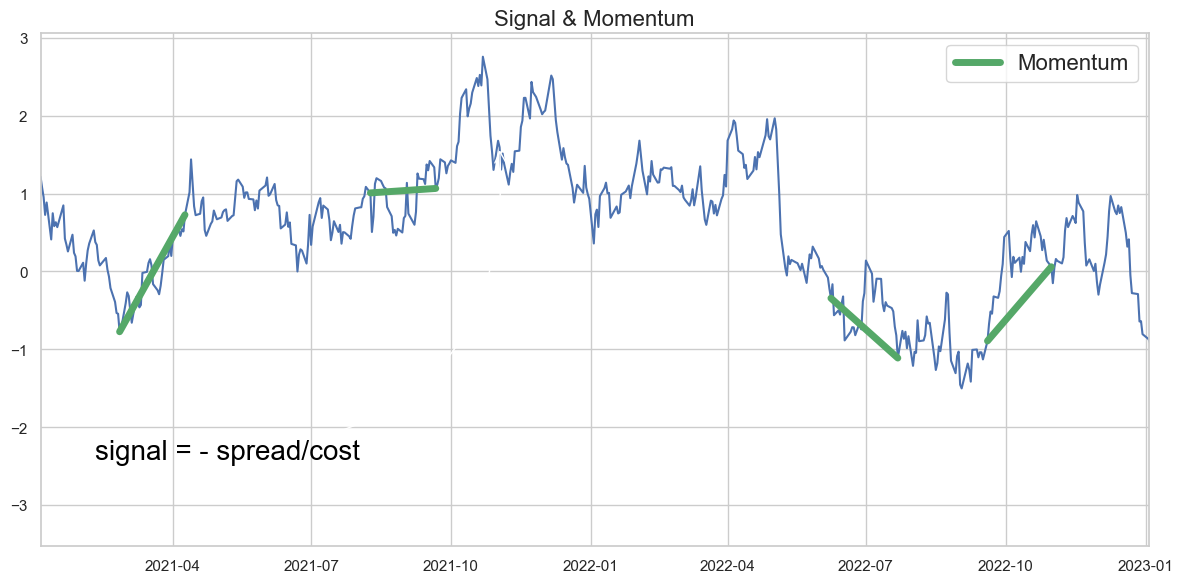

In [94]:
data_out=ou_process-np.average(ou_process)
norm = plt.Normalize(min(data_out), max(data_out))
cmap = cm.get_cmap('RdYlGn_r')

plt.figure(figsize=(12,6))
plt.plot(stats.data.all_dates(),data_out)

plt.plot([stats.data.all_dates()[36],stats.data.all_dates()[36+30]],[data_out[36],data_out[36+30]],lw=5,c='g')
plt.plot([stats.data.all_dates()[150],stats.data.all_dates()[150+30]],[data_out[150],data_out[150+30]],lw=5,c='g')
plt.plot([stats.data.all_dates()[360],stats.data.all_dates()[360+30]],[data_out[360],data_out[360+30]],lw=5,c='g')
plt.plot([stats.data.all_dates()[430],stats.data.all_dates()[430+30]],[data_out[430],data_out[430+30]],lw=5,c='g',label='Momentum')
plt.title('Signal & Momentum',fontsize=16)
plt.annotate(f"signal = - spread/cost", 
             xy=(stats.data.all_dates()[210], data_out[210]),  # Point to annotate
             xytext=(stats.data.all_dates()[25], data_out[210] - 4),  # Position of the label
             arrowprops=dict(facecolor='red', arrowstyle='->', connectionstyle="arc3,rad=.5"),
             fontsize=20, color='black', horizontalalignment='left')
plt.xlim(stats.data.all_dates()[0],stats.data.all_dates()[503])
plt.legend(fontsize=16)
plt.tight_layout()

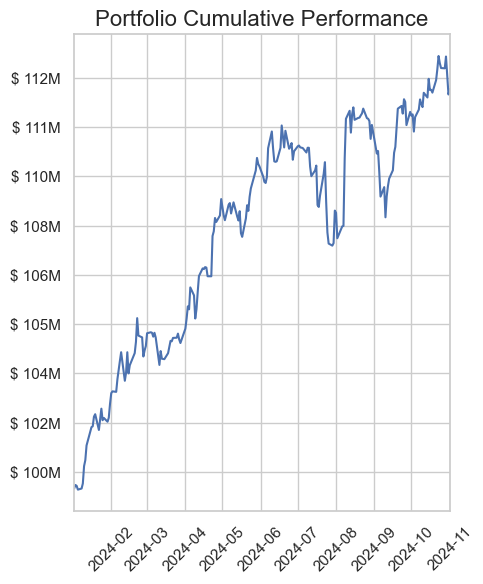

In [95]:
fig,ax=plt.subplots(figsize=(5,6))
plt.plot([results['start_dates'][0]]+results['end_dates'],[1e8]+results['final_vals'])
plt.xlim(results['start_dates'][0],results['end_dates'][-1])
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks_2))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params('x',rotation=45)
plt.title('Portfolio Cumulative Performance',fontsize=16)

plt.tight_layout()
plt.show()

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from iter import iter_all

class spread_tester:
    def __init__(self,data):
        # if used for testing only need industry data
        self.data = data
    def make_ts(self,coef,order):
        # make time series from coefficients and order
        # coef: list of coefficients
        # order: list of orders
        return self.data[order].values@coef
    def loop_make_ts(self,coefs,orders):
        #loop above function
        return np.array([self.make_ts(coef,order) for coef,order in zip(coefs,orders)]).squeeze()
    def coef_matrix(self,coefs,orders):
        frames=[]
        for a,b in (zip(orders,coefs)):
            frames.append(pd.DataFrame(dict(zip(a,b))))
        coef_matrix=pd.concat(frames).fillna(0).reset_index(drop=True) #[self.data.columns] Excluding this so trades with no values are not included
        return coef_matrix
    def weight_matrix(self,coef_matrix,margin):
        prices=self.data.mean(axis=0) #sub out with live price in final implementation
        prices['CONST']=0
        outs=coef_matrix*prices
        return outs.div(outs.abs().sum(axis=1)*margin, axis=0).drop(columns='CONST')
    def cluster_matrix(self,matrix):
        """
        Need to determine uniqueness by pre-clustering
        """
        cluster=MiniBatchKMeans(n_clusters=int(matrix.shape[0]/100),random_state=0)
        matrix['Cluster'] = cluster.fit_predict(matrix)
        return matrix
    
def apply_tstat_mask(stats,coefs,order,max_stat=0.347):
    """
    Applies Filter for MAX Test Stat
    """
    stats=np.array(stats)
    coefs=np.array(coefs)
    order=np.array(order)
    mask_stat=stats<=max_stat #HYPERPARAMETER 1
    stats_m1=stats[mask_stat]
    coefs_m1=coefs[mask_stat]
    order_m1=order[mask_stat]
    return stats_m1,coefs_m1,order_m1
temp=0
def apply_weight_mask(data,stats,coefs,order,weight_mask=1,type='std',margin=0.2):
    """
    Applied filter for maximum imbalance in weights
    Based on either abs = actual imbalance
    or std = standard deviation of weights
    Uses 20% margin as default
    """
    tester=spread_tester(data)
    coef_matrix=tester.coef_matrix(coefs,order)
    weights=tester.weight_matrix(coef_matrix,margin)
    net_weights=weights.sum(axis=1)
    temp=net_weights
    if type=='std':
        weight_avg=net_weights.mean()
        weight_std=net_weights.std()
        mask_weights=(((net_weights-weight_avg)>-(weight_mask*weight_std))&((net_weights-weight_avg)<(weight_mask*weight_std)))
    elif type=='abs':
        mask_weights=np.abs(net_weights)<=weight_mask
    return coef_matrix[mask_weights],stats[mask_weights]

def apply_similarity_mask(data,stats,coef_matrix,corr_threshold=0.95):
    """
    Applies filter for similarity between coefficients
    """
    train_ts=(coef_matrix.values@data[coef_matrix.columns].values.T)
    cluster=MiniBatchKMeans(n_clusters=max(1,int(train_ts.shape[0]/100)),random_state=0)
    preds=cluster.fit_predict(train_ts)
    filtered_coef_matrix=coef_matrix.copy()
    filtered_coef_matrix['Cluster']=preds
    filtered_coef_matrix['TStat']=stats
    filtered_coef_matrix.sort_values('Cluster',inplace=True)
    filtered_coef_matrix=filtered_coef_matrix.reset_index(drop=True)
    out_list=[]
    for group_num in range(max(1,int(train_ts.shape[0]/100))):
        t_stats=list(filtered_coef_matrix[filtered_coef_matrix['Cluster']==group_num]['TStat'])
        grouped_ts=(filtered_coef_matrix[filtered_coef_matrix['Cluster']==group_num].drop(columns=['Cluster','TStat']).values@data[coef_matrix.columns].values.T)
        corr_mat=np.corrcoef(grouped_ts)
        indices_to_drop = set()
        if grouped_ts.shape[0]<2:
            out_list.append(filtered_coef_matrix[filtered_coef_matrix['Cluster']==group_num])
            continue
        for i in range(corr_mat.shape[0]):
            for j in range(i + 1, corr_mat.shape[1]):
                if abs(corr_mat[i, j]) > corr_threshold:
                    if t_stats[i] > t_stats[j]:
                        indices_to_drop.add(i)
                    else:
                        indices_to_drop.add(j)
        to_kill=list(indices_to_drop)
        to_keep = list([item for item in list(range(corr_mat.shape[0])) if item not in to_kill])
        output=filtered_coef_matrix[filtered_coef_matrix['Cluster']==group_num].iloc[to_keep]
        out_list.append(output)
    return pd.concat(out_list).drop(columns=['Cluster','TStat']),np.array(pd.concat(out_list)['TStat'])


In [164]:
data=data_loader()

loaded_data=data.load_price("Utilities",tnt='train')

In [165]:
def apply_weight_mask(data,stats,coefs,order,weight_mask=1,type='std',margin=0.2):
    """
    Applied filter for maximum imbalance in weights
    Based on either abs = actual imbalance
    or std = standard deviation of weights
    Uses 20% margin as default
    """
    tester=spread_tester(data)
    coef_matrix=tester.coef_matrix(coefs,order)
    weights=tester.weight_matrix(coef_matrix,margin)
    net_weights=weights.sum(axis=1)
    temp=net_weights
    if type=='std':
        weight_avg=net_weights.mean()
        weight_std=net_weights.std()
        mask_weights=(((net_weights-weight_avg)>-(weight_mask*weight_std))&((net_weights-weight_avg)<(weight_mask*weight_std)))
    elif type=='abs':
        mask_weights=np.abs(net_weights)<=weight_mask
    return coef_matrix[mask_weights],stats[mask_weights],temp


stats,_,weights,order=iter_all(loaded_data,4)
stats_m1,coefs_m1,order_m1=apply_tstat_mask(stats,weights,order,max_stat=0.25)
coef_matrix,stats_m2,temp=apply_weight_mask(loaded_data,stats_m1,coefs_m1,order_m1,weight_mask=1,type='std')
train_ts=(coef_matrix.values@loaded_data[coef_matrix.columns].values.T)
cluster=MiniBatchKMeans(n_clusters=max(1,int(train_ts.shape[0]/100)),random_state=0)

In [166]:
preds=cluster.fit_predict(train_ts)

In [167]:
pd.DataFrame(np.corrcoef(train_ts[preds==0])).to_clipboard()

In [168]:
np.corrcoef((train_ts[preds==0])[32:36])

array([[1.        , 0.98538361, 0.97791271, 0.97977256],
       [0.98538361, 1.        , 0.97909925, 0.99670358],
       [0.97791271, 0.97909925, 1.        , 0.97802024],
       [0.97977256, 0.99670358, 0.97802024, 1.        ]])

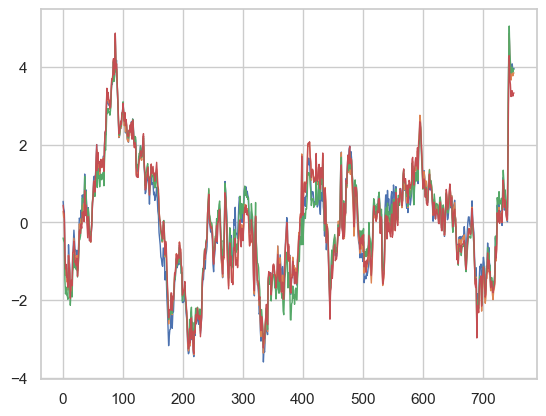

In [169]:
plt.plot((train_ts[preds==0])[32],lw=1)
plt.plot((train_ts[preds==0])[33],lw=1)
plt.plot((train_ts[preds==0])[34],lw=1)
plt.plot((train_ts[preds==0])[35],lw=1)
plt.show()

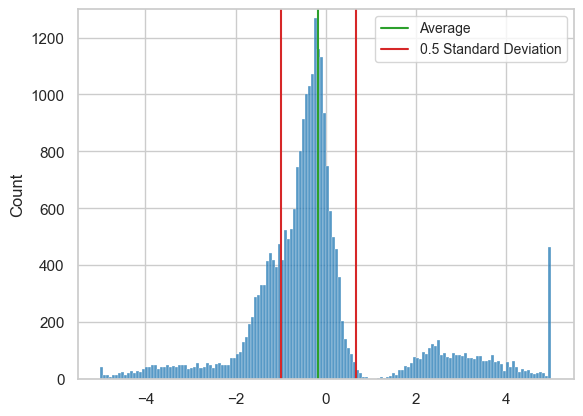

In [170]:
avg=np.average(temp)
std=np.std(temp)
colors=sns.color_palette('tab10')
sns.histplot(temp,bins=150,color=colors[0])
plt.plot([avg,avg],[0,2000],c=colors[2],label='Average')
plt.plot([avg+0.5*std,avg+0.5*std],[0,2000],c=colors[3],label='0.5 Standard Deviation')
plt.plot([avg-0.5*std,avg-0.5*std],[0,2000],c=colors[3])
plt.ylim(0,1300)
plt.legend(fontsize=10)
plt.show()

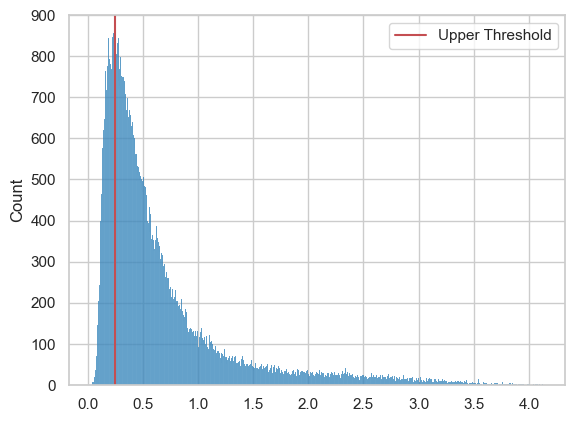

In [171]:
sns.histplot(stats,bins=1000,color=colors[0])
plt.plot([0.25,0.25],[-100,1000],c='r',label='Upper Threshold')
plt.ylim(0,900)
plt.legend()
plt.show()

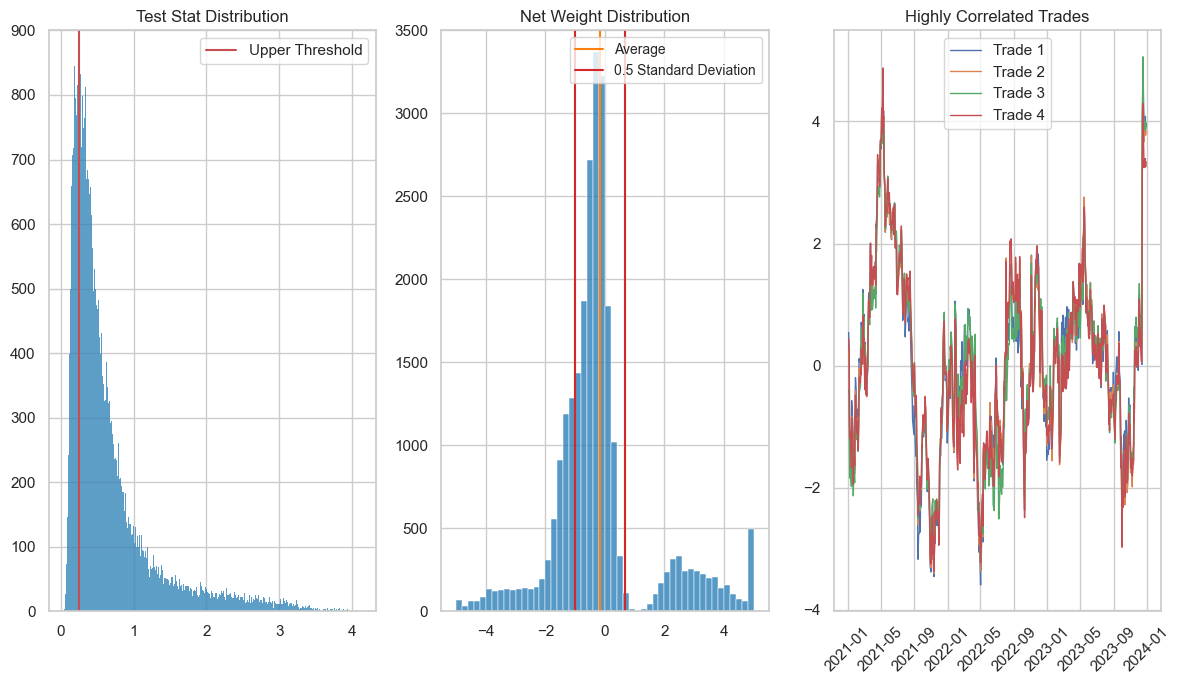

In [185]:
fig, axes = plt.subplots(1, 3, figsize=(12, 7))
avg=np.average(temp)
std=np.std(temp)
colors=sns.color_palette('tab10')
sns.histplot(temp,bins=50,color=colors[0],ax=axes[1])
axes[1].plot([avg,avg],[0,3600],c=colors[1],label='Average')
axes[1].plot([avg+0.5*std,avg+0.5*std],[0,3600],c=colors[3],label='0.5 Standard Deviation')
axes[1].plot([avg-0.5*std,avg-0.5*std],[0,3600],c=colors[3])
axes[1].set_ylim(0,3500)
axes[1].set_ylabel('')
axes[1].set_title('Net Weight Distribution')
axes[1].set_xlim(-5.5,5.5)
axes[1].legend(fontsize=10)

sns.histplot(stats,bins=1000,color=colors[0],ax=axes[0])
axes[0].plot([0.25,0.25],[-100,1000],c='r',label='Upper Threshold')
axes[0].set_ylim(0,900)
axes[0].legend()
axes[0].set_ylabel('')
axes[0].set_title('Test Stat Distribution')

axes[2].plot(stats_m.data.all_dates()[:753],(train_ts[preds==0])[32],lw=1,label='Trade 1')
axes[2].plot(stats_m.data.all_dates()[:753],(train_ts[preds==0])[33],lw=1,label='Trade 2')
axes[2].plot(stats_m.data.all_dates()[:753],(train_ts[preds==0])[34],lw=1,label='Trade 3')
axes[2].plot(stats_m.data.all_dates()[:753],(train_ts[preds==0])[35],lw=1,label='Trade 4')
axes[2].set_title('Highly Correlated Trades')
axes[2].tick_params(axis='x', labelrotation=45)
axes[2].legend()
plt.tight_layout()
plt.show()